## Parte II. Clasificación de flores con regresión logística multiclase.

---

En esta sección del proyecto, se pretende desarrollar un modelo de regresión logística multiclase utilizando el enfoque One-vs-Rest, implementado desde cero con el algoritmo de optimización por descenso del gradiente.

Para este modelo predictivo, se empleará el conjunto de datos de reconocimiento de flores, el cual contiene una serie de imágenes etiquetadas en cinco clases distintas. El objetivo es construir clasificadores binarios independientes, es decir, uno por cada clase, que permitan distinguir entre una clase y el resto.

Antes de la implementación de dicho modelo, se realizará un procesamiento adecuado de los datos y un análisis exploratorio básico, necesario para comprender de mejor manera la distribución de las variables, justificar la elección de las características y preparar el conjunto de datos dado para el entrenamiento del modelo predictivo.

En este Notebook se detallan las siguientes etapas:

- Procesamiento y análisis exploratorio.

- Limpieza y transformación de los datos.

- Entrenamiento de clasificadores binarios para One-vs-Rest.

- Evaluación del rendimiento y visualización de resultados.

Las librerías del lenguaje de programación Python que serán implementadas son las siguientes:

In [ ]:
# Importación de las librerías necesarias para el procesamiento de datos y entrenamiento del modelo

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import zscore
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

Luego de haber importado las librerías necesarias que se van a utilizar, agregamos una parte de código en donde se verifica si el Dataset ha sido descargado y descomprimido correctamente, dado que es necesario que exista en el ordenador donde se ejecuta el entrenamiento para poder acceder a dichos datos.

El código para la verificación es el siguiente:

In [33]:
# Verificando la existencia del Dataset

DATASET_PATH = "flowers"

if not os.path.exists(DATASET_PATH) :
    raise FileNotFoundError(f"\033[91mLa carpeta {DATASET_PATH} no ha sido encontrada en la ubicación del Notebook.\033[0m")
else :
    print("\033[92mDataset encontrado en la ruta del Notebook.\033[0m")

Dataset encontrado en la ruta del Notebook.


De esta manera se ha verificado si el Dataset existe o no en la misma ruta que el Notebook. Si no se encuentra la carpeta "flowers" dentro de la ruta del Notebook, detiene la ejecución con un mensaje de advertencia, si le encuentra, informa que el Dataset se encuentra correctamente ubicado.

#### Descripción del conjunto de datos (Dataset).

---

El conjunto de datos en cuestión corresponde a un repositorio de Kaggle titulado como "Flowers Recognition" [1]. El dataset contiene más de 4,000 imágenes de flores clasificadas en cinco categorías distintas:

- Margarita (Daisy).

- Diente de león (Dandelion).

- Rosa (Rose).

- Girasol (Sunflowes).

- Tulipán (Tulip).

Ahora, cada una de las clases se encuentra en una carpeta diferente. Las imágenes dentro de las carpetas varían en tamaño y proporciones, por ello, deben ser procesadas previa implementación del entrenamiento del modelo matemático, para poder utilizar dicho conjunto de datos correctamente.

A continuación, se procede a realizar la carga y preparación inicial de las imágenes con un aplanamiento, en donde cada imagen es redimensionada a $64\times64$ píxeles en escala de grises y se convierte a un vector unidimensional, generando una matriz de características que representa cada imagen como un vector numérico de longitud $64\times64=4096$, procedimiento efectuado por medio del siguiente código:

In [34]:
# Clases disponibles dentro del conjunto de datos
classes = os.listdir(DATASET_PATH)

print(f"\033[1mClases detectadas:\033[0m \033[92m{classes}\033[0m \n")

IMG_SIZE = 64 # con esta variable se va a redimensionar el tamaño de todas las imágenes dada la diferencia en la que provienen

# Variables para cargar las imágenes y las etiquetas de las clases

data = [] # Lista de imágenes
labels = [] # Lista de etiquetas

# Cargando las imágenes en la lista de imágenes y las etiquetas en la lista de etiquetas

for label in classes :
    
    path = os.path.join(DATASET_PATH, label) # Tomando cada clase del conjunto de datos principal
    count = 0
    
    for img_name in os.listdir(path) : # Se recorre cada una de las clases (carpetas dentro de "flowers")
        
        try :
            
            img_path = os.path.join(path, img_name) # Se obtiene la imagen actual
            img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)) # Se redimensiona la imagen
            img_array = np.array(img) / 255.0
            img_array = img_array.flatten() # Aplanando para la regresión
            
            data.append(img_array) # Se agrega la imagen a la lista
            labels.append(label) # Se agrega la clase a la que pertenece a la lista de etiquetas
            
            count += 1
            
        except Exception as e :
            continue
        
# Convirtiendo la lista de imagenes y lista de etiquetas en matrices

_X_ = np.array(data)
_Y_ = np.array(labels)

print(f"\033[1mMatriz de imagenes ->\033[0m \n\033[92m{_X_}\033[0m\n")
print(f"\033[1mMatriz de etiquetas ->\033[0m \033[92m{_Y_}\033[0m\n")

Clases detectadas: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] 

Matriz de imagenes -> 
[[0.55294118 0.55294118 0.54509804 ... 0.50980392 0.49411765 0.49019608]
 [0.84705882 0.85490196 0.88627451 ... 0.69411765 0.65490196 0.61176471]
 [0.45882353 0.45490196 0.41960784 ... 0.20392157 0.09411765 0.33333333]
 ...
 [0.34117647 0.34117647 0.24705882 ... 0.27058824 0.34509804 0.18431373]
 [0.70588235 0.67058824 0.65098039 ... 0.19215686 0.18431373 0.03921569]
 [0.19215686 0.20784314 0.18431373 ... 0.19607843 0.24313725 0.02352941]]

Matriz de etiquetas -> ['daisy' 'daisy' 'daisy' ... 'tulip' 'tulip' 'tulip']



En la salida, se puede observar que fueron obtenidas 4317 imágenes, y para cada uno se detectaron las características, creando una matriz de $m$ muestras, en donde cada muestra posee una cantidad $n$ de características. Además, se creó la lista de etiquetas para cada una de las muestras, indicando la clase a la que pertenecen.

A continuación, se visualizan algunas imágenes representativas para tener una idea general del contenido visual que se le presentará al modelo, justificando la necesidad de transformar las imágenes en vectores aplanados para el entrenamiento.

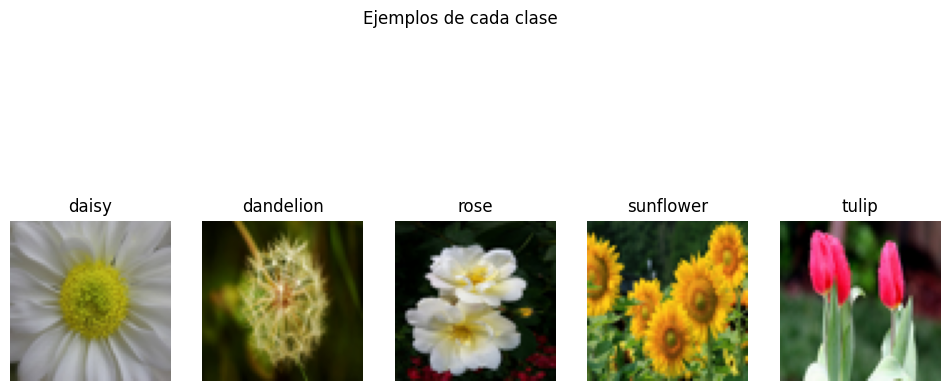

In [35]:
# Mostrando una imagen por clase

plt.figure(figsize=(12,6)) # tamaño de la figura que mostrara las imagenes

for i, class_name in enumerate(classes) : # iterando sobre todas las clases para mostrar la imagen por cada una
    
    # construccion de la ruta de la img actual
    img_path = os.path.join(DATASET_PATH, class_name, os.listdir(os.path.join(DATASET_PATH, class_name))[0]) 
    
    img = Image.open(img_path).resize((IMG_SIZE, IMG_SIZE)).convert("RGB") # se abre la imagen, se redimensiona y se convirte a RGB
    plt.subplot(1, 5, i+1) # subplot para mostrar la imagen actual en una fila de 1 x 5
    plt.imshow(img) # mostrando la imagen en la celda del subplot
    plt.title(class_name) # titulo de la imagen (clase a la que pertenece)
    plt.axis("off") # se ocultan los ejes
    
    
plt.suptitle("Ejemplos de cada clase") # titulo general para toda la figura generada
plt.show() # se muestra la figura con las imagenes de ejemplo

Para que el descenso del gradiente funcione correctamente, las características deben estar en la misma escala, por ello, se aplica la normalización estándar, asegurando que todas las variables tengan media cero y desviación estándar uno, así se asegura igualmente la convergencia, evitando que algunas características dominen el aprendizaje.

Además, dado que las clases originales son categóricas, es decir, nombres de flores, se requiere codificarlas numéricamente para aplicar el algoritmo de regresión logística. Para ello, se utiliza **Label Encoding**, que convierte etiquetas de texto a números entre $0\land(C-1)$, siendo $C$ el número de clases.

En este momento, se procede a realizar una normalización, se estandarizan los valores numéricos de cada pixel usando **StandardScaler**, con el objetivo de mejorar la convergencia del método del descenso del gradiente en el entrenamiento. Asimismo, se codifican las clases con valores numéricos de cero a cuatro para facilitar la clasificación multiclase.

In [36]:
# Escalando las características

scaler = StandardScaler() # instancia del escalador estandar (normaliza los datos para que tengan media 0 y desviacion estandar 1)
X_Scaled = scaler.fit_transform(_X_) # se ajusta el escalador a los datos de entrada (transformacion de los datos a escalado estandar)

print("\033[1mDatos escalados ->\033[0m")
print(f"\033[92m{X_Scaled}\033[0m\n")

# Codificando las etiquetas

encoder = LabelEncoder() # instancia del codificador de etiquetas (convierte etiquetas de texto a valores numericos)
Y_Encoded = encoder.fit_transform(_Y_) # se ajusta el codificador a las etiquetas de clases y se transforman a numeros de cero a cuatro

print(f"\033[1mEtiquetas/clases codificadas ->\033[0m \033[92m{Y_Encoded}\033[0m\n")

# Mostrando las clases codificadas

for i, name in enumerate(encoder.classes_) :
    print(f"\033[1m{i}:\033[0m \033[94m{name}\033[0m") # se imprime cada clase original junto con su valor numerico codificado

Datos escalados ->
[[ 0.57704808  0.58896151  0.69160425 ...  0.70980905  0.69662547
   1.0417738 ]
 [ 1.56653401  1.65440392  1.77712023 ...  1.394433    1.33790104
   1.52019426]
 [ 0.26041259  0.24303865  0.29233401 ... -0.42637537 -0.89874302
   0.42445708]
 ...
 [-0.13538178 -0.15823186 -0.25666258 ... -0.17874543  0.10227251
  -0.1619938 ]
 [ 1.09158076  1.00406894  1.02848852 ... -0.47007477 -0.53900306
  -0.73301177]
 [-0.63672132 -0.62868695 -0.4562977  ... -0.4555083  -0.30439005
  -0.79474344]]

Etiquetas/clases codificadas -> [0 0 0 ... 4 4 4]

0: daisy
1: dandelion
2: rose
3: sunflower
4: tulip


En este caso, podemos notar que el conjunto de datos con los que se va a trabajar para entrenar y evaluar el modelo, cargado anteriormente desde el ordenador, ha sido escalado y se expresa como una matriz de $m$ muestras normalizadas $\times$ $n$ características, en donde para el caso mostrado $n=12,289$ y $m=4317$. Este dato se comprende mejor al observar un DataFrame creado a partir de los datos escalados en la etapa de preprocesamiento.

Además, los datos de las etiquetas de clases por cada muestra han sido codificados en un número de 0 a 4, en donde cada número representa una clase, mostrando su definición en la salida final.

#### Previa al procesamiento de datos.

---

Antes de entrenar un modelo de regresión logística multiclase, es fundamental un preprocesamiento riguroso sobre los datos, con el fin de mejorar la calidad del entrenamiento y asegurar que el modelo generalice adecuadamente, para ello, se realiza una limpieza de los datos, detectando valores atípicos y eliminando de datos duplicados, así como un análisis de las clases y balanceo de los datos. A continuación, se detallan las fases:

**Eliminación de registros duplicados.**

Se verifica si existen registros duplicados dentro del conjunto de imágenes procesadas, lo cual puede ocurrir si múltiples archivos poseen un contenido idéntico o si se repiten en diferentes clases.

Sea $X\in\mathbb{R}^{m\times n}$ la matriz de entrada con $m$ muestras y $n$ características, se verifica si existen filas repetidas en $X$.

In [37]:
# Creando un DataFrame temporal para verificar si existen duplicados

df_temp = pd.DataFrame(X_Scaled) # DataFrame temporal con los datos escalados
df_temp["label"] = Y_Encoded # Se añade una columna con las etiquetas codificadas

print(f"\033[1mDataFrame ->\033[0m\n\033[92m{df_temp}\033[0m\n")

# Verificando duplicados

num_duplicates = df_temp.duplicated().sum() # Contador de filas completamente duplicadas (considerando caracteristicas y etiquetas)

print(f"\033[1mRegistros duplicados:\033[0m \033[91m{num_duplicates}\033[0m\n")

# Eliminando los registros duplicados si existen

df_temp = df_temp.drop_duplicates() # Eliminando filas duplicadas
X_Scaled = df_temp.drop("label", axis=1).values # Actualizando los datos escalados (no incluye la columna 'label')
Y_Encoded = df_temp["label"].values # Se actualizan las etiquetas codificadas (solo incluye la columna 'label')

print(f"\033[1mDatos escalados actualizados ->\033[0m \n\033[92m{X_Scaled}\033[0m\n")
print(f"\033[1mDatos de etiquetas actualizados ->\033[0m \033[92m{Y_Encoded}\n\033[0m")

DataFrame ->
             0         1         2         3         4         5         6  \
0     0.577048  0.588962  0.691604  0.671156  0.674689  0.809938  0.696446   
1     1.566534  1.654404  1.777120  1.554609  1.656756  1.768157  1.579767   
2     0.260413  0.243039  0.292334 -0.040880 -0.169059  0.050830  0.076804   
3    -0.940164 -1.140653 -0.057027 -0.977076 -1.164959 -0.073614 -0.977907   
4    -0.966550 -0.974610 -0.705842 -1.016634 -1.109631 -0.720723 -0.753781   
...        ...       ...       ...       ...       ...       ...       ...   
4312  1.830397  1.861958 -0.344003  1.791955  1.808908 -0.285169  1.645686   
4313  0.695786  0.547451 -0.106936  0.776643  0.508706 -0.621168  0.788733   
4314 -0.135382 -0.158232 -0.256663 -0.357341 -0.348874 -0.247836 -0.160506   
4315  1.091581  1.004069  1.028489  1.409565  1.449277  1.382381  0.973308   
4316 -0.636721 -0.628687 -0.456298 -0.251854 -0.265883 -0.036281 -0.028667   

             7         8         9  ...     12279 

En la salida mostrada, se puede observar primeramente el DataFrame que se hablaba anteriormente, el cual muestra la matriz de orden $4317\times12289$ en donde han sido almacenadas las 12289 características que contiene cada una de las 4317 muestras normalizadas cargadas al conjunto de datos en el principio, siendo estos los datos escalados con los que se va a trabajar el entrenamiento del modelo y se medirá su rendimmiento.

De igual manera, se observa que en dicho gran conjunto de datos hubo un total de 2 registros duplicados los cuales fueron eliminados, y posteriormente se mostró nuevamente la matriz de datos escalados en su forma de lista, así como la matriz de etiquetas codificadas de dimensión $1\times4317$, en donde cada número representa la etiqueta verdadera codificada de cada muestra, es decir, la clase a la que pertenecen las 2500 muestras del conjunto de entrada.

**Detección de Outliers.**

Los valores atípicos pueden afectar negativamente el rendimiento del modelo, para detectarlos se utiliza el método **Z-score**, que mide cuántas desviaciones estándar se aleja cada valor de la media, es decir, observaciones que se alejan significativamente del resto de los datos, calculado por:

$$Z=\frac{x - \mu}{\sigma}$$

Donde $\mu$ es la media y $\sigma$ la desviación estándar. Un valor absoluto $Z > 3$ se considera un **Outlier**.

A continuación, se procede a calcular el z-score para cada una de las muestras en el conjunto de datos escalados, encontrar las características por muestra que posean $zscore>3$ y que por lo tanto, se considera outlier y finalmente, calcular si una muestra posee más del 10% de sus características como outliers. Luego, se procede a eliminar las muestras que cumplan con la condición dada.

In [38]:
# calculando el z-score para todas las muestras dentro de los datos escaldos

z_scores = zscore(X_Scaled) # Se calcula z-score para todas las muestras
print(f"\033[1mz-score ->\033[0m\n\033[92m{z_scores}\033[0m\n")

# se determina si una característica dentro de cada muestra es outlier (z_scores > 3 || z_scores < -3)

outlier_sample = np.abs(z_scores) > 3
print(f"\033[1mCaracteristicas de las muestras que son outliers ->\033[0m\n\033[91m{outlier_sample}\033[0m\n")

# se calcula el porcentaje de caracteristicas outlier dentro de cada muestra

outlier_porcents_per_sample = np.mean(outlier_sample, axis=1)
print(f"\033[1mPorcentaje de outlier en cada muestra ->\033[0m \n\033[91m{outlier_porcents_per_sample}\033[0m\n")

# identificando las muestras que poseen mas del 10% de outliers en sus caracteristicas

samples_to_remove = np.where(outlier_porcents_per_sample > 0.10)[0]
print(f"\033[1mMuestra a eliminar por outlier ->\033[0m\n\033[91m{samples_to_remove}\033[0m\n")

# se eliminan las muestras con mas del 10% de outliers del conjunto de datos escalado

X_Cleaned = np.delete(X_Scaled, samples_to_remove, axis=0)

print(f"\033[1mCantidad de muestras eliminadas consideradas outliers ->\033[0m \033[91m{len(samples_to_remove)}\033[0m\n")

X_Scaled = X_Cleaned

print(f"\033[1mConjunto de datos escalado sin outliers ->\033[0m \n\033[92m{X_Scaled}\033[0m\n")


z-score ->
[[ 0.57697944  0.58889225  0.69161788 ...  0.70951975  0.69635612
   1.04145461]
 [ 1.56624032  1.65409263  1.77691087 ...  1.39402594  1.33750359
   1.51978103]
 [ 0.26041595  0.24304798  0.29242966 ... -0.42646924 -0.89869366
   0.42425924]
 ...
 [-0.1352884  -0.15813138 -0.25645415 ... -0.1788819   0.10212189
  -0.16207636]
 [ 1.0913951   1.00390539  1.02843295 ... -0.47016113 -0.53902557
  -0.73298208]
 [-0.63651391 -0.6284796  -0.45604826 ... -0.45559717 -0.30445943
  -0.79470162]]

Caracteristicas de las muestras que son outliers ->
[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]

Porcentaje de outlier en cada muestra -> 
[0. 0. 0. ... 0. 0. 0.]

Muestra a eliminar por outlier ->
[]

Cantidad de muestras eliminadas consideradas outliers -> 0

Conjunto de da

En la primera salida, se define el z-score para cada muestra, en donde se indica por cada valor su alejamiento en desviaciones estándar de la media de datos, luego, dado que se ha establecido que, si algún dato tiene como $z-score > 3$ entonces se considera **outlier**, el z-score de todas las características es evaluado para verificar si cumplen dicha condición, mostrando la matriz de booleanos, indicando si una característica es outlier (true) o no (false), estos son obtenidos y se muestra en la siguiente salida, posteriormente, se calcula el porcentaje de outliers dentro de cada muestra, mostrando el vector de porcentaje de outlier para todas las muestras, luego se verifica para cada muestra si ese porcentaje es mayor que 10%, si alguna cumple, se considera outlier y se almacena en un vector de muestras a eliminar que es impreso en consola verificando las muestras exactas del conjunto de datos escalado que serán eliminados, luego indica la cantidad de muestras eliminadas dentro del conjunto y finalmente se muestra de nuevo la matriz de datos escalados pero con las muestras outliers eliminadas, asegurando tener datos con los que el entrenamiento del modelo no será distorsionado, ni las predicciones serán alteradas por valores atípicos.

En la salida, los resultados demuestran que no existen outliers que puedan distorsionar el entrenamiento del modelo, no hay ninguna muestra en donde haya una cantidad de características outlier que no permitan el correcto desarrollo del modelo, por lo tanto, ninguna muestra es eliminada del conjunto de datos escalado, y el conjunto de datos mostrado es exactamente el mismo antes de la validación de existencia de outliers.

**Distribución de clases.**

Una fase importante es verificar si el conjunto de datos está balanceado, esto dado que la regresión logística multiclase puede verse sesgada si hay clases con demasiadas o muy pocas muestras.

Para ello, se grafica la distribución de los datos de muestra por cada clase:

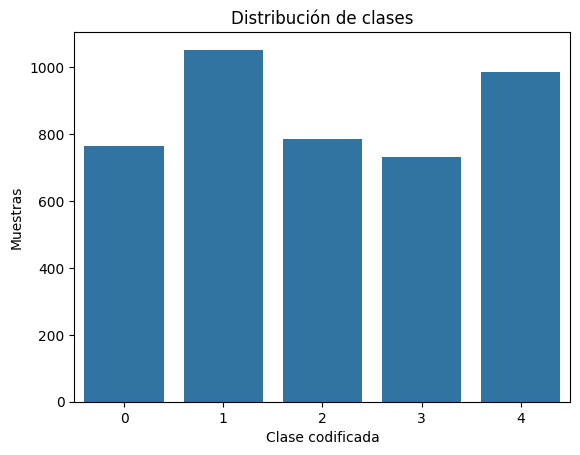

In [39]:
def plot_class_distribution(y_encoded, title="Distribución de clases"):
    sns.countplot(x=y_encoded)
    plt.title(title)
    plt.xlabel("Clase codificada")
    plt.ylabel("Muestras")
    plt.show()

plot_class_distribution(Y_Encoded)

Habiendo tomado una perspectiva de como se ve el balanceo de los datos por cada una de las clases, se procede a realizar una verificación del máximo y mínimo conteo para encontrar la razón de desbalanceo, si esta supera el valor de **THRESHOLD** entonces se aplica submuestro para balancear los datos de entrada y los de etiquetas codificadas.

In [40]:
counts = Counter(Y_Encoded)

max_count = max(counts.values())
min_count = min(counts.values())

imbalance_ratio = max_count / min_count
print(f"\033[1mRazon de desbalanceo ->\033[0m \033[94m{imbalance_ratio}\033[0m\n")

THRESHOLD = 1.5

if imbalance_ratio > THRESHOLD:
    
    print("\033[92mClases desbalanceadas detectadas.\033[0m\n")

    sampler = RandomOverSampler(random_state=42)
    print("\033[94mAplicando sobremuestreo . . .\033[0m")    
    
    X_balanced, y_balanced = sampler.fit_resample(X_Scaled, Y_Encoded)
    
    plot_class_distribution(y_balanced, title="Distribución de clases balanceada")

    X_scaled = X_balanced
    y_encoded = y_balanced

else:
    print("\033[92mNo hay desbalanceo significativo. No se aplica corrección.\033[0m")


Razon de desbalanceo -> 1.439124487004104

No hay desbalanceo significativo. No se aplica corrección.


En la gráfica anterior se puede observar que efectivamente, la distribución de clases es balanceada, aunque la clase 3 (Sunflower) ahora posee dos registros menos, indicando que es la clase que contenía datos duplicados, pese a la eliminación de esos dos registros, la distribución sigue siendo adecuada dado que la razón de desbalanceo permite continuar con el entrenamiento sin aplicar submestreo para balancear los datos, concluyendo que la distribución de clases es adcuada, por lo tanto, se continúa con el proceso y se asegura que tanto el entrenamiento como la evaluación del modelo no se verán afectados.

#### Regresión logística multiclase.

---

La regresión logística es un modelo lineal de clasificación que estima la **probabilidad** de pertenencia a una clase basado en parámetros de entrada mediante la función **sigmoide**.

La **función sigmoide** se utiliza para transformar la salida lineal del modelo, la cual es una combinación lineal de características, en una probabilidad entre $0$ y $1$, siendo su expresión matemática

$$\sigma(z)=\frac{1}{1+e^{-z}}$$

Donde $z=\mathbf{W}^T\cdot\mathbf{X}+b$ es la combinación lineal de los pesos y las características.

Las propiedades importantes de $\sigma(z)$ son:

- $\sigma(z)\in(0,1)$

- Cuando $z\to-\infty,\ \sigma(z)\to0$

- Cuando $z\to+\infty,\ \sigma(z)\to1$

- $\sigma(0)=0.5$

Dado un vector de características de una flor $\mathbf{X}\in\mathbb{R}^{m\times n}$, el modelo binario estima lo siguiente:

$$\hat{y}=\sigma(\mathbf{W}^T\mathbf{X}+b)=\frac{1}{1+e^{-(\mathbf{W}^T\mathbf{X}+b)}}$$

Donde 

- $\sigma$ es la función **sigmoide**.

- $\mathbf{W}\in\mathbb{R}^{n\times k}$ es el vector de pesos, que mide el impacto que cada característica tendrá sobre la probabilidad de pertenecer a una clase.

- $b\in\mathbb{R}$ es el sesgo, el cual es un valor constante que se agrega en la primera columna del vector de pesos y tiene como objetivo escalar la función de probabilidad para desviarla del origen.

- $\hat{y}\in(0,1)$ es la probabilidad predicha.

Siendo $m$ el número de muestras, $n$ el número de características y $k$ el número de clases.

El vector de pesos representa los parámetros que definen la relación entre las características, es decir, atributos de las flores, y su probabilidad de pertenencia a cada una de las clases.

Suponiendo ciertas características como largo del sépalo, ancho del sépalo, largo del pétalo, ancho del pétalo. Entonces cada peso $w_i$ en el vector $\mathbf{W}$ cuantifica cuánto influye esa característica en la probabilidad de que una flor pertenezca a la clase positiva, es decir, a la clase de la que se está evaluando en el clasificador, si pertenece o no a dicha clase. El modelo predice la **probabilidad** de que una muestra pertenezca a la clase positiva.

Ahora, para abordar la **clasificación multiclase** se utiliza la estrategia **One-vs-Rest**, entrenando un clasificador binario para clase $k$, y se pretende predecir si una muestra determinada pertenece a la clase $k$ o no, considerando que los parámetros que se desean optimizar para realizar predicciones correctas son los datos que se pueden controlar y ajustar, en este caso, el vector de pesos $\mathbf{W}$.

**Función de pérdida logística.**

La regresión logística modela la probabilidad de una clase positiva $y=1$ dada una entrada $\mathbf{X}$ como:

$$\hat{y}=\sigma(\mathbf{w}^T\mathbf{x}+b)=\frac{1}{1+e^{-(\mathbf{w}^T\mathbf{x}+b)}}$$

El modelo planteado asume que $y\sim\text{Bernoulli}(\hat{y})$, es decir, que la variable aleatoria $y$ se modela como una **variable binaria** que toma valores como 0 o 1 y se define como las etiquetas verdaderas, con una probabilidad de éxito (1) igual a $\hat{y}$, decir que $y$ se distribuye como una Bernoulli con parámetro $\hat{y}$ es equivalente a decir que $P(y=1)=\hat{y},\quad P(y=0)=1-\hat{y}$, por lo que la verosimilitud para una muestra es:

$$P(y\mid\mathbf{x})=\hat{y}^y(1-\hat{y})^{1-y}$$

En donde $y$ es la etiqueta verdadera que toma valores como 0 o 1, $\hat{y}=\sigma(z)$ es la probabilidad de que $y=1$.

Para $m$ muestras independientes, la log-verosimilitud o entropía cruzada (Log-Loss) es:

$$\log\mathcal{L}(\mathbf{w},b)=\left[y^{(i)}\log(\hat{y}^{(i)})+(1-y^{(i)})\log(1-\hat{y}^{(i)})\right]$$

Por lo tanto, la función de pérdida logística se define como el negativo del logaritmo de la verosimilitud promedio:

$$\mathcal{J}(\mathbf{w},b)=-\left[y^{(i)}\log(\hat{y}^{(i)})+(1-y^{(i)})\log(1-\hat{y}^{(i)})\right]$$

Resultando en la **función de pérdida logística** para clasificación binaria. 

Finalmente, el objetivo es **minimizar** esta función de costo con respecto al parámetro $\mathbf{W}$, optimizarlo para reducir el error en la clasificación lo más posible al predecir la clase con el modelo predictivo implementado $\hat{y}$.

Para minimizar la función de pérdida se utiliza el método **descenso del gradiente**, en el cual se trabaja con los gradientes de la función respecto de sus variables, en este caso, el gradiente de Log-Loss respecto de $\mathbf{W}$, siendo el gradiente:

$$\frac{\partial\mathcal{J}}{\partial \mathbf{w}}=\left(\hat{y}^{(i)}-y^{(i)}\right)\mathbf{x}^{(i)}$$

Para cada iteración del algoritmo de descenso del gradiente, se actualizan los parámetros así

$$\mathbf{W}:=\mathbf{W}-\alpha\cdot\frac{\partial\mathcal{J}}{\partial\mathbf{W}}$$

Donde $\alpha$ es la tasa de aprendizaje.

A continuación, se implementa el modelo binario. Se define la función **sigmoide**, la función de **pérdida logística** y se define la función para entrenar el modelo de regresión logística binaria, es decir, optimizar los parámetros (vector de pesos) por medio del algoritmo de optimización **descenso del gradiente** calculado con momento para optimizar mejor los parámetros y evitar que el algoritmo converja en mínimos locales.

In [41]:
# Entrenamiento con descenso del gradiente para regresion logistica binaria

# funcion sigmoide que convierte cualquier valor real en un valor entre 0 y 1

def sigmoid(z) :
    return 1 / (1 + np.exp(-z))

# funcion de perdida logistica (Log-Loss) -> mide que tan buenas son las predicciones probabilisticas

def logistic_loss(y_true, y_pred) :
    epsilon = 1e-8 # valor perqueño para evitar Log(0)
    return -np.mean(y_true * np.log(y_pred + epsilon) + (1 - y_true) * np.log(1 - y_pred + epsilon))

# funcion para entrenar el modelo de regresion logistica binaria (clasificador binario) con gradiente descendente

def train_logistc_regression(X, y, alpha, max_iterations, TOL, lambd=0.01, beta=0.9) :
    
    m, n = X.shape # m -> numero de muestras y n -> numero de caracteristicas
    X = np.hstack([np.ones((m, 1)), X]) # se incluye el sesgo en el vector de entrada como la primera columna en las caracteristicas
    
    print(f"\033[1mMuestras:\033[0m \033[94m m = {m}\033[0m \033\1m- Caracteristicas:\033[0m \033[94mn = {n}\033[0m\n")
    
    w = np.zeros(n + 1) # inicializando pesos en cero considerando la dimension de X habiendo incluido el sesgo
    v = np.zeros(n + 1) # inicializando factor de momento
    
    losses = [] # lista para guardar la perdida en cada iteracion
    
    for iter in range(max_iterations) : # iterando en un maximo de 3000 iteraciones
                
        z = np.dot(X, w)  # calculo del valor lineal z
                
        y_pred = sigmoid(z) # aplicando sigmoide para obtener la probabilidad
                
        # Calculando el gradiente de la perdida con respecto a cada parametro
        
        gradient = (1 / m) * np.dot(X.T, (y_pred - y)) + (lambd / m) * w # derivada parcial respecto de los pesos
                
        # actualizando los parametros por descenso del gradiente
        
        v = beta * v + (1 - beta) * gradient # calculando factor de momento        
        w -= alpha * v # se actualiza w 
                
        # Calculando y guardando perdida para graficar posteriormente
        
        loss = logistic_loss(y, y_pred) + (lambd / (2 * m)) * np.sum(w ** 2) # calculo de perdida aplicando regularizacion L2  
        
        if loss < TOL : # se verifica si la perdida es menor que una tolerancia para detener el metodo
            print(f"\033[92mEl metodo converge luego de {iter} iteraciones.\033[0m\n")
            break
        
        losses.append(loss)
                
        # mostrar datos esenciales cada 100 iteraciones como feedback del entrenamiento
        
        if iter % 100 == 0 : 
            
            print(f"\033[1mIteracion:\033[0m \033[94m{iter}\033[0m\n")
            print(f"\033[1mz ->\033[0m \033[91m{z}\033[0m\n")
            print(f"\033[1mSigmoid ->\033[0m \033[91m{y_pred}\033[0m\n")
            print(f"\033[1mGradiente ->\033[0m \033[91m{gradient}\033[0m\n\033[1m\n")
            print(f"\033[1mParametro actualizado:\033[0m\n\n\033[1mw ->\033[0m \033[91m{w}\033[0m\n\033[1m\n")
            print(f"\033[1mError =\033[0m \033[91m{loss}\033[0m\n")
            
        if iter == (max_iterations - 1) : print("\033[92mOptimizacion detenida despues de 3000 iteraciones\033[0m\n")
            
    return w, losses #b, losses # retorna el vector de pesos optimizado y lista de perdidas

# funcion para graficar la curva de perdida durante el entrenamiento

def plot_loss_curve(losses, c) :
    plt.plot(losses)
    plt.title(f"Curva de perdida por entrenamiento de {c}")
    plt.xlabel("Iteraciones")
    plt.ylabel("Perdida logistica")
    plt.grid(True)
    plt.show()

Se ha definido la función sigmoide, la función de pérdida logística, se implementó el algoritmo de descenso del gradiente con momento para optimizar los parámetros de la función de predicción (sigmoide) dada una entrada (vector de muestras), además, se define la función que permite visualizar gráficamente como se reduce progresivamente la pérdida o error (pérdida logística), hasta converger en un número infinitesimalmente cercano a 0.

Ahora, habiendo realizado la implementación del modelo binario, se usará la función **train_logistic_regression** para entrenar el clasificador binario para cada clase usando la estrategia **One-vs-Rest** para clasificación multiclase.

Para cada una de las clases $c_k$, se entrena un modelo binario que responde

$$y^{(i)}=\begin{cases}1,&\text{Si el ejemplo pertenece a la clase }k\\0,&\text{En caso contrario}\end{cases}$$

Luego, para predecir, se aplicará cada clasificador y se elegirá la clase con la mayor probabilidad

$$\hat{y}=\text{arg max }\sigma(\mathbf{W}^T\cdot\mathbf{X}+b)$$

In [42]:
# funcion que entrena un clasificador por cada clase utilizando la estrategia One-vs-Rest

def train_ovr(X, y, num_classes, alpha=0.1, max_iterations=3000, TOL=0.01) :
            
    classifiers = {} # Diccionario para guardar los parametros optimizados por cada clase
    all_losses = {} # Diccionario para guardar las curvas de perdida por cada clase
    
    # Iterando en el numero de clases para entrenar un clasificador binario para cada clase
    
    for c in range(num_classes) : 
        
        print(f"\033[94mEntrenando clasificador para clase {c}\033[0m\n")
        
        # Creando vector binario de etiquetas: 1 si la etiqueta pertenece a la clase c, 0 si no pertenece
        
        y_binary = (y == c).astype(int)
        
        # Entrenando modelo de regresion logistica binaria con descenso del gradiente
        
        w, losses = train_logistc_regression(X, y_binary, alpha, max_iterations, TOL)
        
        print(f"\033[1mParametros optimizados para clasificador {c} ->\033[0m \n \033[1mw =\033[0m \033[92m{w}\033[0m \n")
        
        plot_loss_curve(losses, c) # Se muestra la curva de perdidas para el clasificador actual en entrenamiento
        
        classifiers[c] = w # Guardando parametros optimizados del clasificador c (vector de pesos)
        all_losses[c] = losses # Guardando la curva de perdida de la clase actual
        
    return classifiers, all_losses # se retornan los c clasificadores y sus curvas de perdida

# funcion para predecir a que clase pertenece cada muestra de un conjunto de datos de entrada usando los
# clasificadores binarios ya entrenados siguiendo la estrategia OvR

def predict_ovr(X, classifiers) :   
        
    m = X.shape[0] # numero de muestras
    print(f"\033[1mNumero de muestras:\033[0m \033[92m{m}\033[0m")
    
    X = np.hstack([np.ones((m, 1)), X]) # se agrega la columna de sesgo a las caracteristicas para tener igual dimension con los w optimizados

    num_classes = len(classifiers) # numero de clasificadores (total de clases - 1 clasificador por cada clase)
    print(f"\033[1mNumero de clases:\033[0m \033[92m{num_classes}\033[0m\n")
    
    # matriz que almacena la probabilidad para cada muestra de pertenecer a cada clase
    
    probs = np.zeros((m, num_classes)) # (shape m x num_classes)
    
    # calculando la probabilidad de pertenecer a cada clase usando los clasificadores entrenados
    
    print("\033[94mProbabilidades de que cada muestra pertenezca a cada clase\033[0m\n") 
    
    for c, w in classifiers.items() :
                
        z = np.dot(X, w) # se calcula el valor lineal z para todas las muestras, proyectando sobre W y agregado el sesgo 

        # se calcula la probabilidad de cada muestra de pertenecer a la clase c generando un vector de probabilidades
        
        _sigmoid = sigmoid(z) # se aplica sigmoide para convertir el vector z en el vector de probabilidades
        
        probs[:, c] = _sigmoid # se almacena el vector de probabilidades de cada muestra de pertenecer a la clase c
        
        print(f"\033[1mProbabilidad de pertenencia de cada muestra a la clase {c} ->\033[0m\n\033[92m{_sigmoid}\033[0m\n")
    
    # generando un vector con la clase predicha para cada muestra
    
    max_prob = np.argmax(probs, axis=1) # para cada muestra se toma la clase con mayor probabilidad
    
    print(f"\033[1mClase predicha para cada muestra ->\033[0m\n\033[92m{max_prob}\033[0m\n")
        
    return max_prob # retorna lel vector de clases predichas para cada muestra

# funcion para graficar todas las curvas de perdida por entrenamiento de cada clasificador binario OvR

def plot_all_loss_curves(all_losses) :
    
    plt.figure(figsize=(10,6))
    
    # iterando sobre cada clasificador y su curva de perdida
    
    for c, losses in all_losses.items() :
            plt.plot(losses, label=f"Clase {c}") # dibujando curva de perdida para cada clase
        
    plt.title("Curvas de perdida por clase") # titulo del grafico -> funcion de costo graficada por clase
    
    # etiquetas para los ejes x e y
    plt.xlabel("Iteraciones") # iteraciones
    plt.ylabel("Perdida logistica") # error en la iteracion 
     
    plt.legend()
    plt.grid(True)
    plt.show()    

Ahora, la estrategia One-vs-Rest ha sido implementada para convertir cada clasificador binario a un problema multiclase, en donde se define la función **train_ovr** que realiza el entrenamiento para cada clasificador binario, crea un vector binario que almacena 1 si la muestra pertenece a la clase c, 0 si no pertenece, y llama a la función **train_logistic_regression** para entrenar el clasificador para esa clase en específico, obteniendo los parámetros óptimos para predecir si una flor pertenece a la clase específica para la que se está entrenando el clasificador, luego almacena los parámetros óptimos en un diccionario con la clave igual a la clase actual, y almacena en otro diccionario la curva de pérdida generada para el entrenamiento de dicho clasificador.

Luego se implementa la función de predicción **predict_ovr** el cual realiza como punto principal, la matriz de probabilidades de dimensión $m\times num\_classes$, inicializada en cero, en la cual se almacena el vector resultado de evaluar $z$ en sigmoide para medir la probabilidad de pertenencia de cada muestra a la clase c actual sobre la que se está iterando. Para cada clase, se almacena el vector de probabilidades y posteriormente, para cada muestra se obtiene la máxima probabilidad con **softmax**, es decir, la clase con la mayor probabilidad de pertenencia para cada una de las muestras del conjunto de datos de entrada, prediciendo entonces, la clase a la que cada muestra pertenece.

Además, se define la función **plot_all_loss_curves**, que realiza una sola figura con la curva de pérdida generada durante el entrenamiento de cada clasificador, pudiendo observar como los parámetros fueron optimizados por medio de visualizar como la curva de error se reduce progresivamente hasta converger a un valor infinitesimalmente cercano a 0, pudiendo obtener un modelo predictivo para cada clase, y predecir si una muestra específica pertenece a la clase o no, implementando clasificadores binario.

#### Entrenamiento del modelo.

---

Definidos todos los procedimientos de entrenamiento, predicción y gráfico de curvas de pérdida para un clasificador binario por cada clase, ahora se pasa a la parte del entrenamiento de los modelos utilizando los métodos creados. A continuación se detalla el entrenamiento:

Entrenando clasificador para clase 0

Muestras:  m = 2157 m- Caracteristicas: n = 12288

Iteracion: 0

z -> [0. 0. 0. ... 0. 0. 0.]

Sigmoid -> [0.5 0.5 0.5 ... 0.5 0.5 0.5]

Gradiente -> [0.32290218 0.04972567 0.03616511 ... 0.02944178 0.01612144 0.00647932]


Parametro actualizado:

w -> [-3.22902179e-03 -4.97256718e-04 -3.61651067e-04 ... -2.94417773e-04
 -1.61214364e-04 -6.47931719e-05]


Error = 0.6931471642087222

Iteracion: 100

z -> [-3.05675156 -5.71899305 -2.98231344 ... -3.76853033  5.61370712
 -0.40628453]

Sigmoid -> [0.04492688 0.00327227 0.04823132 ... 0.02256503 0.99636573 0.39980335]

Gradiente -> [ 0.03976278 -0.02876467 -0.03002716 ... -0.02710476 -0.02893763
 -0.02868306]


Parametro actualizado:

w -> [-1.76064434e+00 -1.76703355e-02 -2.90916730e-03 ...  6.98031819e-04
  1.16332536e-02  6.21325036e-03]


Error = 0.1410189479129805

Iteracion: 200

z -> [-4.08612181 -6.21289048 -2.59186466 ... -3.17612681  4.19108053
 -1.319492  ]

Sigmoid -> [0.01652656 0.0019994

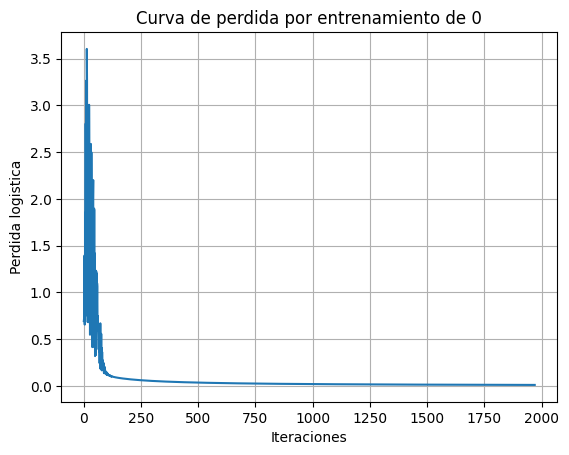

Entrenando clasificador para clase 1

Muestras:  m = 2157 m- Caracteristicas: n = 12288

Iteracion: 0

z -> [0. 0. 0. ... 0. 0. 0.]

Sigmoid -> [0.5 0.5 0.5 ... 0.5 0.5 0.5]

Gradiente -> [0.25614279 0.05954046 0.03120454 ... 0.03177178 0.00774203 0.04048265]


Parametro actualizado:

w -> [-2.56142791e-03 -5.95404638e-04 -3.12045390e-04 ... -3.17717847e-04
 -7.74202678e-05 -4.04826528e-04]


Error = 0.6931471635051075

Iteracion: 100

z -> [-1.86055978 -3.0470827  -0.90252695 ... -3.51445797 -3.04365395
  1.16251758]

Sigmoid -> [0.13463782 0.04534359 0.28853149 ... 0.02890365 0.04549224 0.76178987]

Gradiente -> [0.02690755 0.004913   0.00525347 ... 0.00511641 0.00462921 0.00493378]


Parametro actualizado:

w -> [-1.15673966 -0.00492137  0.00873984 ... -0.00947595  0.00787035
 -0.0264905 ]


Error = 0.16182327145023426

Iteracion: 200

z -> [-2.3938094  -4.11326849 -1.4643447  ... -4.10158709 -2.9865047
  1.43406024]

Sigmoid -> [0.08364598 0.01609108 0.18780371 ... 0.01627707 0.0

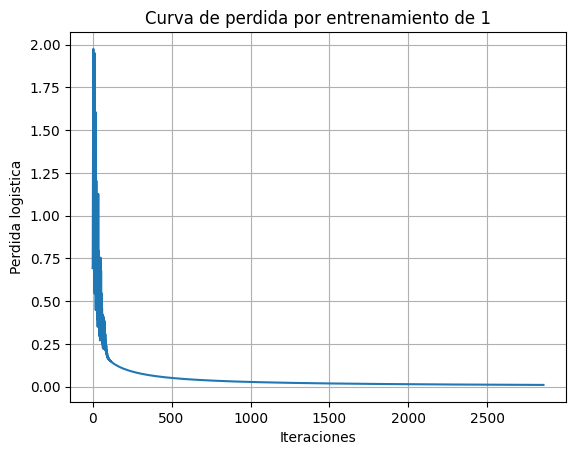

Entrenando clasificador para clase 2

Muestras:  m = 2157 m- Caracteristicas: n = 12288

Iteracion: 0

z -> [0. 0. 0. ... 0. 0. 0.]

Sigmoid -> [0.5 0.5 0.5 ... 0.5 0.5 0.5]

Gradiente -> [ 0.31826611  0.02248073  0.04197286 ... -0.02078309  0.00297942
 -0.03402428]


Parametro actualizado:

w -> [-3.18266110e-03 -2.24807265e-04 -4.19728572e-04 ...  2.07830885e-04
 -2.97942403e-05  3.40242837e-04]


Error = 0.693147162888996

Iteracion: 100

z -> [-3.39527181  2.57374571 -3.54095028 ...  4.01868069 -2.29819251
 -2.00724569]

Sigmoid -> [0.03244356 0.92915267 0.02816926 ... 0.98234079 0.09127277 0.11844427]

Gradiente -> [ 0.05387727  0.00115774  0.00103313 ... -0.00070986 -0.00043029
  0.00054815]


Parametro actualizado:

w -> [-1.30913385 -0.0339412  -0.02422031 ...  0.01942569  0.01986347
  0.00544038]


Error = 0.13177186367303914

Iteracion: 200

z -> [-4.18344119  3.0440276  -4.62960236 ...  4.73150229 -3.07443802
 -2.65247811]

Sigmoid -> [0.015017   0.95452398 0.00966433 ... 

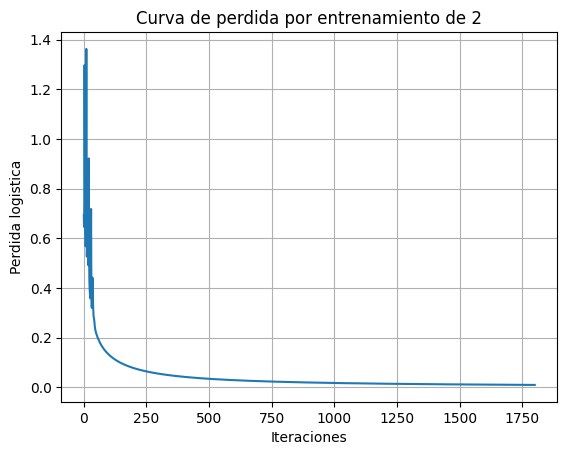

Entrenando clasificador para clase 3

Muestras:  m = 2157 m- Caracteristicas: n = 12288

Iteracion: 0

z -> [0. 0. 0. ... 0. 0. 0.]

Sigmoid -> [0.5 0.5 0.5 ... 0.5 0.5 0.5]

Gradiente -> [ 0.3307835  -0.03842709 -0.06602024 ... -0.01509236 -0.03078551
  0.00418661]


Parametro actualizado:

w -> [-3.30783496e-03  3.84270859e-04  6.60202382e-04 ...  1.50923580e-04
  3.07855066e-04 -4.18661018e-05]


Error = 0.6931471655544412

Iteracion: 100

z -> [ 2.70650892 -2.48756754 -3.13724745 ... -2.86100073 -2.76710466
 -2.39120291]

Sigmoid -> [0.93740963 0.07673435 0.04159672 ... 0.05411545 0.05912788 0.08384598]

Gradiente -> [0.05590994 0.00225182 0.00205909 ... 0.00282204 0.00225697 0.00258052]


Parametro actualizado:

w -> [-1.44089662e+00 -1.04367720e-02  4.30096742e-03 ... -9.61130126e-03
  4.61926991e-03  9.35590241e-04]


Error = 0.11285234603736904

Iteracion: 200

z -> [ 3.12740307 -3.14539744 -4.10006405 ... -3.45629511 -3.4913131
 -3.08035803]

Sigmoid -> [0.95800905 0.0412730

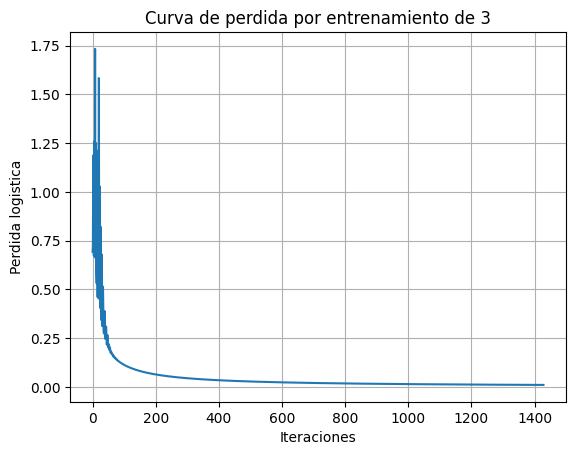

Entrenando clasificador para clase 4

Muestras:  m = 2157 m- Caracteristicas: n = 12288

Iteracion: 0

z -> [0. 0. 0. ... 0. 0. 0.]

Sigmoid -> [0.5 0.5 0.5 ... 0.5 0.5 0.5]

Gradiente -> [ 0.27190542 -0.03829122 -0.01237056 ... -0.00888341  0.00794738
 -0.00476353]


Parametro actualizado:

w -> [-2.71905424e-03  3.82912181e-04  1.23705573e-04 ...  8.88341175e-05
 -7.94737537e-05  4.76352759e-05]


Error = 0.6931471625640611

Iteracion: 100

z -> [-2.76765564 -2.2694917   1.31598491 ... -1.83680402 -2.46114968
 -1.73075309]

Sigmoid -> [0.05909724 0.09368136 0.78851292 ... 0.13742971 0.07862701 0.15049128]

Gradiente -> [ 0.04666473  0.00064756  0.00083738 ... -0.00063186 -0.00011259
 -0.00125324]


Parametro actualizado:

w -> [-1.14340827  0.00459303  0.00460151 ...  0.01007206  0.00581942
  0.02522021]


Error = 0.14028059583709443

Iteracion: 200

z -> [-3.50357413 -2.58457207  1.98667375 ... -2.45398671 -3.23994647
 -2.18675615]

Sigmoid -> [0.02921071 0.07013796 0.87939079 ...

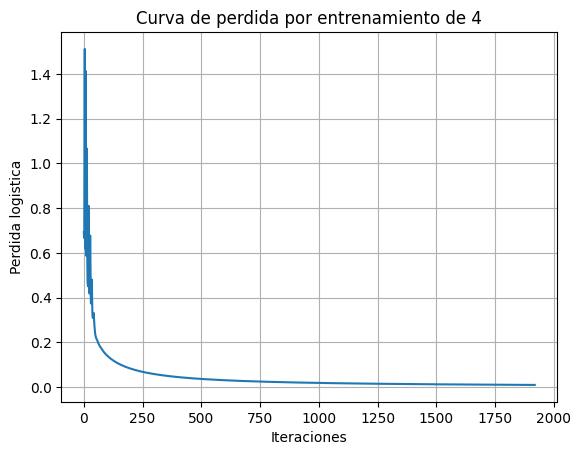

In [ ]:
# Separando el conjunto de datos en datos de entrada para entrenamiento y datos de entrada para prueba del modelo

X_train, X_test, Y_train, Y_test = train_test_split(
    X_Scaled, Y_Encoded, test_size=0.5, random_state=42, stratify=Y_Encoded
)

# Entrenando el modelo OvR

num_classes = len(np.unique(Y_train)) # obteniendo el numero de clases unicas de las etiquetas codificadas

# entrenando los clasificadores binarios por cada clase utilizando la estrategia OvR y los datos para entrenamiento

classifiers, all_losses = train_ovr(X_train, Y_train, num_classes) # se obtienen los clasificadores entrenados y sus curvas de perdida

Como se puede observar en las curvas de pérdida de cada clase por cada 100 iteraciones, la pérdida en cada una de las clases fue disminuyendo progresivamente a lo largo de las iteraciones, hasta converger en un valor prácticamente nulo. Al finalizar el entrenamiento, todas las funciones de costo alcanzaron un valor de pérdida igual a $\text{loss}=0.00\dots$, lo que evidencia que el entrenamiento del modelo por medio del descenso del gradiente logró optimizar eficazmente los parámetros del modelo en todas las clases, los cuales se presentan en un resumen al final del entrenamiento de cada clasificador a continuación.

In [44]:
print("\033[94mParametros optimizados para cada clasificador\033[0m\n")

for c, (w) in classifiers.items() :
    
    print(f"\033[1mClasificador {c}\033[0m\n\n\033[1mw_{c} ->\033[0m\n\033[92m{w}\033[0m") #\n\033[1mb_{c} =\033[0m\033[92m{b}\033[0m\n")
    print(f"\033[94mCon estos parametros se va a obtener la probabilidad aplicando sigmoide de que una muestra pertenezca a la clase {c}\033[0m\n")

Parametros optimizados para cada clasificador

Clasificador 0

w_0 ->
[-3.41095356 -0.03253566 -0.02679451 ...  0.0095604   0.03900325
 -0.02083204]
Con estos parametros se va a obtener la probabilidad aplicando sigmoide de que una muestra pertenezca a la clase 0

Clasificador 1

w_1 ->
[-2.48975162 -0.0084194   0.02301496 ... -0.01993569  0.03388746
 -0.05006124]
Con estos parametros se va a obtener la probabilidad aplicando sigmoide de que una muestra pertenezca a la clase 1

Clasificador 2

w_2 ->
[-3.15472084e+00 -6.39632365e-02 -3.29755385e-02 ...  6.40416343e-02
  5.23289257e-02 -3.04117488e-03]
Con estos parametros se va a obtener la probabilidad aplicando sigmoide de que una muestra pertenezca a la clase 2

Clasificador 3

w_3 ->
[-3.22082213e+00  3.38782132e-03  3.24725141e-02 ... -3.12863222e-02
  2.64801829e-03 -9.04071970e-03]
Con estos parametros se va a obtener la probabilidad aplicando sigmoide de que una muestra pertenezca a la clase 3

Clasificador 4

w_4 ->
[-2.846775

Resumen general para todos los clasificadores.

Luego de haber obtenido los parámetros óptimos para los modelos de clasificación binaria por medio del entrenamiento de cada uno de los clasificadores, se procede a realizar la predicción sobre datos de prueba y evaluar el rendimiento y desempeño del modelo de regresión logística multiclase.

In [45]:
# Prediccion sobre el conjunto de datos de prueba usando los clasificadores binarios OvR entrenados

y_pred = predict_ovr(X_test, classifiers) # se calcula la probabilidad para cada muestra de pertenecer a una clase

Numero de muestras: 2157
Numero de clases: 5

Probabilidades de que cada muestra pertenezca a cada clase

Probabilidad de pertenencia de cada muestra a la clase 0 ->
[1.75427354e-03 7.83814921e-05 1.43270192e-02 ... 8.56992425e-03
 9.98619485e-01 3.52429577e-02]

Probabilidad de pertenencia de cada muestra a la clase 1 ->
[1.06798525e-02 8.66103914e-04 1.76237335e-02 ... 5.62670432e-04
 9.80921006e-03 9.83541288e-01]

Probabilidad de pertenencia de cada muestra a la clase 2 ->
[7.84975700e-04 9.91819308e-01 9.69315654e-05 ... 9.99478449e-01
 2.79618350e-03 5.32055794e-03]

Probabilidad de pertenencia de cada muestra a la clase 3 ->
[9.93154859e-01 7.18431960e-03 8.96735967e-04 ... 5.67552070e-03
 2.18814999e-03 4.22268618e-03]

Probabilidad de pertenencia de cada muestra a la clase 4 ->
[0.00137697 0.01141248 0.98572958 ... 0.00755803 0.001828   0.01354746]

Clase predicha para cada muestra ->
[3 2 4 ... 2 0 1]



Una vez finalizado el entrenamiento del modelo One-vs-Rest sobre el conjunto de datos escalado de entrenamiento, se procedió a realizar la predicción y evaluación del mismo utilizando el conjunto de datos de prueba. Este proceso permitió confirmar que el modelo es capaz de aprender los patrones presentes en los datos, lo cual se evidenció a través de la observación de las curvas de pérdida y el análisis del comportamiento del descenso del gradiente.

Los resultados obtenidos en la predicción para nuevas muestras provenientes de los datos de prueba, en donde las salidas de los resultados de la predicción muestran que se ha evaluado el modelo para un conjunto de entrada de 2157 muestras que se deben clasificar como una de 5 clases de flores, luego se muestra el vector de probabilidades, en donde cada dato del vector para cada clase es la probabilidad de que la muestra pertenezca a la clase en cuestión calculada por medio de la función sigmoide utilizando el vector de pesos ótpimo para cada clasificador luego de su entrenamiento. Finalmente se muestra un vector con la clase predicha para cada muestra, vector calculado por medio de obtener la probabilidad más alta para una muestra específica entre las 5 clases, por ejemplo, en la muestra 0 del conjunto, se puede ver que la probabilidad más alta de pertenencia fue calculada por el clasificador 3, lo que indica que dicha muestra se clasifica como clase 3, dado que es la máxima probabilidad para esa muestra.

Finalmente, se procede a realizar la evaluación del modelo en los datos de prueba, a continuación, se presentan los resultados obtenidos.

#### Resultados y evaluación del modelo.

---

Los resultados obtenidos fueron presentados de manera estructurada mediante un DataFrame, lo que permitió visualizar y analizar formalmente las predicciones del modelo por clase, facilitando la interpretación y validación del desempeño de la implementación.

In [46]:
df_pred = pd.DataFrame(y_pred, columns=["Clase predicha"]) # Creando DataFrame de los resultados de la prediccion luego de haber entrenado al modelo

print(f"\033[1m{df_pred}\033[0m") # Mostrando tabla de predicciones

      Clase predicha
0                  3
1                  2
2                  4
3                  2
4                  0
...              ...
2152               4
2153               1
2154               2
2155               0
2156               1

[2157 rows x 1 columns]


Se muestra una tabla que contiene las predicciones realizadas por el modelo, donde cada fila representa una instancia y la columna "Clase predicha" indica la etiqueta asignada por el modelo para esa instancia. Esta visualización textual es útil para verificar directamente los resultados numéricos, aunque puede ser difícil de interpretar cuando el número de predicciones es muy grande tal y como sucede en este caso, por lo que se muestran las primeras cuatro y las últimas cuatro predicciones y la clase predicha para esa instancia.

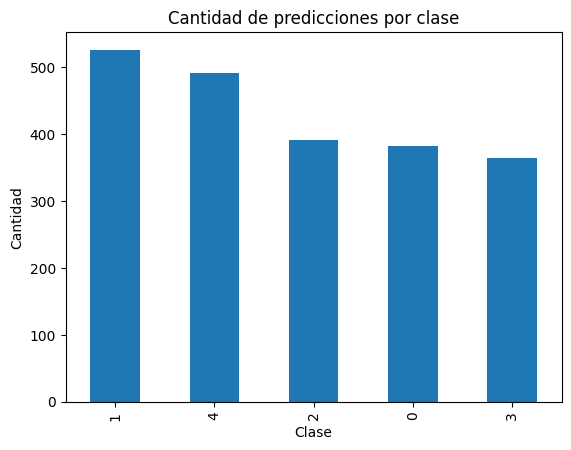

In [47]:
counts = df_pred["Clase predicha"].value_counts() # Conteo de las predicciones acertadas por cada una de las clases

# Grafico de barras para mostrar las predicciones acertadas por cada clase

counts.plot(kind='bar')

plt.title("Cantidad de predicciones por clase")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

Por ello, una forma más intuitiva de entender la distribución de las clases predichas es mediante un gráfico de barras que muestra la cantidad de predicciones por cada clase. En este caso, se observa que todas las predicciones fueron correctas, para cada clase las predicciones fueron las esperadas lo que resalta la eficiencia del modelo en la clasificación de flores.

El modelo de **regresión logística multiclase** ha sido entrenado siguiendo la estrategia **One-vs-Rest** optimizando la función de costo con el método del **descenso de gradiente**, aplicando la evaluación sobre el conjunto de prueba, con el modelo previamente entrenado. A continuación, se presentan los puntos clave del desempeño del modelo.

Se aplicó la métrica estándar de **Scikit-Learn**, en donde cada fila corresponde a una de las clases, las columnas indican lo siguiente:

- **Precisión:** De las veces que el modelo predijo esa clase, ¿En cuántas de ellas acertó?

- **Recall:** De todas las muestras que realmente eran de esa clase, ¿Cuántas detectó?

- **F1-Score:** Promedio armónico entre precisión y recall, es decir, un resumen del rendimiento general.

- **Support:** Cantidad real de muestras de esa clase en el conjunto de prueba.

Las filas finales indican información general del desempeño del modelo:

- **Accuracy:** Exactitud global, proporción total de aciertos en todas las clases.

- **Macro avg:** Promedio simple de precisión, recall y F1 entre clases.

- **Weighted avg:** Promedio ponderado según el número de muestras por clase.

In [48]:
# Evaluando el rendimiento del modelo con metricas de clasificacion: precision, exhaustividad y F1-score por clase

# target_name -> para que las clases aparezcan con sus nombres reales no en su codificacion numerica
print(f"\033[1m{classification_report(Y_test, y_pred, target_names=encoder.classes_)}\033[0m") # se imprime un reporte de clasificacion

              precision    recall  f1-score   support

       daisy       1.00      1.00      1.00       382
   dandelion       1.00      1.00      1.00       526
        rose       1.00      1.00      1.00       392
   sunflower       1.00      1.00      1.00       365
       tulip       1.00      1.00      1.00       492

    accuracy                           1.00      2157
   macro avg       1.00      1.00      1.00      2157
weighted avg       1.00      1.00      1.00      2157



El reporte de clasificación generado permite conocer la efectividad del modelo creado, qué tan bien el modelo reconoce cada una de las clases. En el caso de la evaluación por métricas de clasificación del modelo implementado, luego de realizar una predicción evaluada sobre el conjunto de datos de prueba, obtenemos del reporte los siguientes resultados:

- Para la clase **Daisy**: De todas las veces que el modelo predijo, acertó el 100% de las veces (precisión), detectó correctamente el 100% de las muestras reales de Daisy (recall), tiene un balance entre ambas métricas del 100%, habiendo 382 muestras reales de la clase Daisy en los datos de prueba.

- Para la clase **Dandelion**: En las predicciones del modelo, acertó el 100% de las veces, detectó correctamente el 100% de las muestras reales de Dandelion, con un balance entre ambas métricas del 100%, igualmente con existencia de 526 muestras reales de la clase Dandelion en los datos de prueba.

- Para la clase **Rose**: El modelo acertó el 100% de las veces, detectó correctamente el 100% de las muestras reales de la clase Rose, con un balance del 100% entre las métricas, probado con 392 muestras reales de la clase Rose en los datos de prueba.

- Para la clase **Sunflower**: Acertó su predicción el 100% de las veces, detectó correctamente el 100% de las muestras reales de la clase Sunflower, obtuvo un balance del 100%, probado con 365 muestras reales de la clase Sunflower en los datos de prueba.

- Para la clase **Tulip**: El modelo acertó el 100% de las veces, detectó correctamente el 100% de las muestras reales de la clase Tulip, obtuvo un balance del 100% y fue probado con 492 muestras reales de la clase Tulip dentro de los datos de prueba.

En cuanto a la información general, el modelo acertó el 100% de las 2157 predicciones (accuracy), el promedio simple de cada métrica entre todas las clases fue del 100%.

De igual manera, para cada uno de los clasificadores binarios por cada clase, se obtuvo la **curva de pérdida** durante el entrenamiento. A continuación, se procede a mostrar una visualización general de las curvas de pérdida, mostrando la reducción progresiva del error al momento de entrenar los modelos de clasificación binaria.

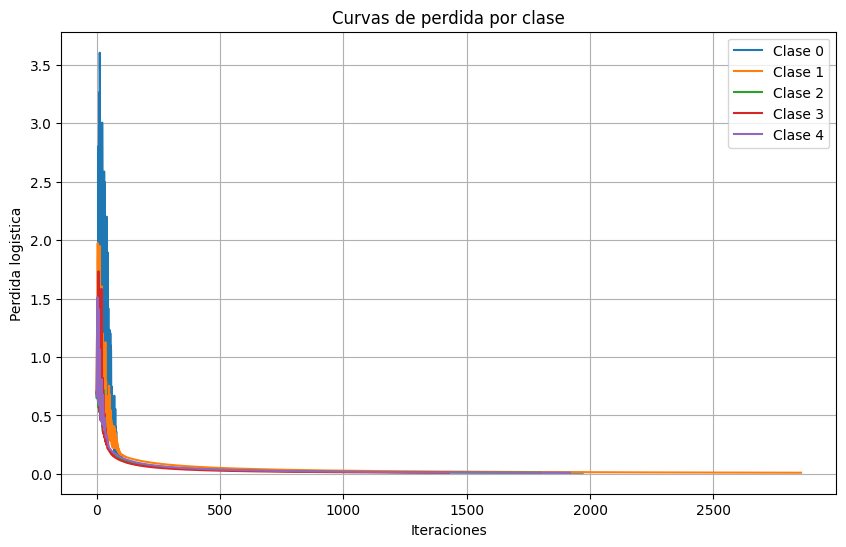

In [49]:
# Visualizando la evolucion de la perdida por clase

plot_all_loss_curves(all_losses) # graficando como disminuye la funcion de costo (error) para cada clasificador (uno por clase) en todas las epocas

En la gráfica de pérdida por clase, se observa un comportamiento distintivo para cada una de las curvas correspondientes al entrenamiento, todas las clases presentan inicialmente una pérdida elevada, reflejando una etapa de exploración del modelo. 

A medida que avanzan las iteraciones, las curvas comienzan a descender progresivamente. Las clases logran una convergencia suave y temprana hacia una pérdida cercana a cero, lo que indica que el modelo pudo ajustar eficazmente sus parámetros para esas clases.

Finalmente, se presenta una matriz de confusión que proporciona una vista general del número de predicciones correctas e incorrectas para cada una de las clases, siendo útil para identificar clases que tienden a ser confundidas entre sí.

La matriz de confusión es una herramienta que permite evaluar el rendimiento de un modelo de clasificación. En ella, se comparan las etiquetas reales con las predicciones del modelo. Los valores ubicados en la diagonal principal representan las predicciones correctas, mientras que los valores fuera de la diagonal indican errores de clasificación, es decir, veces en que el modelo confundió una clase con otra.

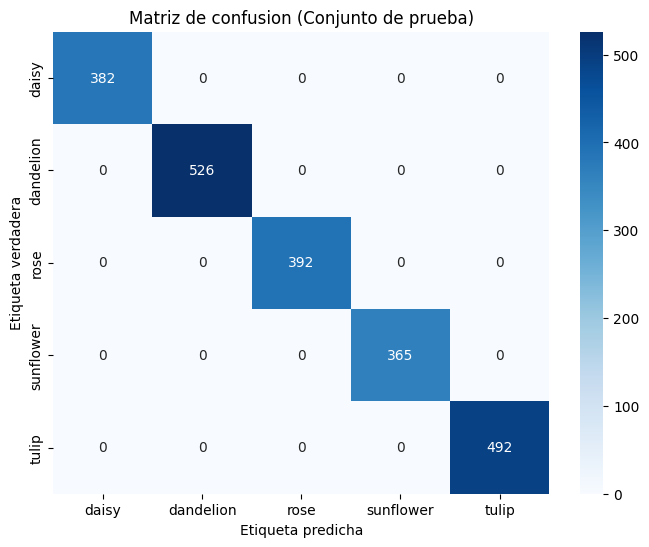

In [50]:
# Matriz de confusion

# se calcula la matriz de confusion que muestra la cantidad de veces en las que el modelo acerto en la prediccion o se equivoco en cada clase

cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8,6))

# se visualiza la matriz de confusion como un mapa de calor para facilitar la interpretacion

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)

plt.title("Matriz de confusion (Conjunto de prueba)")
plt.xlabel("Etiqueta predicha")
plt.ylabel("Etiqueta verdadera")
plt.show()

En la matriz obtenida se puede observar un rendimiento perfecto del modelo: las clases daisy, dandelion, sunflower y tulip fueron clasificadas correctamente en todos los casos (382 aciertos para daisy, 526 para dandelion, 392 para rose, 365 para sunflower y 492 para tulip). 

En general, el modelo muestra una excelente capacidad de clasificación, con una diagonal muy marcada, lo que refleja un alto nivel de precisión en las predicciones.

#### Conclusión.

---

En resumen, se implementó exitosamente un modelo de regresión logística multiclase utilizando descenso del gradiente y la estrategia One-vs-Rest. 

Se prepararon los datos mediante limpieza, codificación y normalización, lo que permitió obtener resultados **aceptables** en la clasificación de imágenes de flores. El modelo, construido desde cero, demostró un rendimiento sólido a pesar de su simplicidad. 

Este proyecto evidenció la utilidad de los métodos numéricos en aprendizaje automático, en este caso, para un **reconocimiento de flores** eficaz. Finalmente, se completó todo el proceso de entrenamiento, evaluación y análisis efectivo del modelo de **regresión logística multiclase**.

#### Referencias.

---

[1] A. Mamaev, *Flowers Recognition Dataset*, Kaggle, [Online]. Available: https://www.kaggle.com/datasets/alxmamaev/flowers-recognition